# Seq2Seq

- Seq2Seq network는 **두 개의 RNN 네트워크**로 이루어집니다. 기존의 vanila RNN 이나 LSTM 구조는 하나의 RNN 네트워크였다면 Seq2Seq network는 **입력시퀀스를 받는 RNN 네트워크 1개(Encoder)**, **출력 시퀀스를 담당하는 네트워크 1개(Decoder)**로 총 2개의 네트워크 구성으로 이루어집니다.
-  입력 네트워크에서는 입력 시퀀스를 받아들여 이것을 하나의 **Vector(Context Vector)**로 요약 합니다. 즉, 입력 네트워크(Encoder)의 목적은 입력 시퀀스의 정보를 고정된 길이의 vector로 잘 **요약**하는 것입니다. 
- 출력 네트워크에서는 입력 네트워크의 출력 값인 Vector와 각 Hidden cell의 output 값이 입력으로 들어가면서 출력을 하게 됩니다. 
- LSTM과 같은 모델에 비해서 Seq2Seq 모델이 번역분야에서 더욱 잘 작동하는 이유는 번역 작업의 특성을 찾아보면 그 해답을 찾을 수 있습니다. 번역 작업에 있어, **문장 전체를 다 보고 번역하는 것**과, **하나의 단어 단위로 번역하는 것**에는 차이가 있습니다. **Seq2Seq 네트워크는 문장 전체(하나의 Sequence)를 다 보고 vector로 그 정보를 요약하기 때문에, 문장 전체가 정확히 다 끝난 것인지 확신할 수 없는 LSTM 구조에 비해 훨씬 더 좋은 성능을 보이게 됩니다.**

## 실습
- 해당 자료에서는 일반적 NLP과정에서 Seq2Seq를 적용해보겠습니다.

참고 자료 : https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

### 패키지 import

In [ ]:
#공유 드라이브 연결
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('gdrive/MyDrive/DoVie/Week1 Seq2seq/')

Mounted at /content/gdrive/


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU를 사용하기 위한 코드

### 데이터 파일 로딩
- 해당 데이터트 수천 개의 영어-프랑스어 번역 쌍입니다.
- 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터 크기가 매우 큽니다. 그래서 해당 예제에서는 약간의 트릭을 써서 데이터에서 등장한 단어만 사용하여 embeding 하도록 데이터를 다듬었습니다.

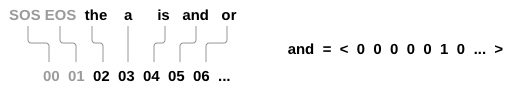

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다. 이 모든 것을 추적하기 위해 우리는 단어→색인(word2index)과 색인→단어(index2word) 사전, 그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도 word2count 를 가진 Lang 이라는 헬퍼 클래스를 사용합니다.

### Lang Class

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.


In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.



In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서 최대 길이는 10 단어 (종료 문장 부호 포함)이며 “I am” 또는 “He is” 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에 아포스트로피는 대체 됨)

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를 위한 전체 과정:

- 텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.

- 텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.

- 쌍을 이룬 문장들로 단어 리스트를 생성합니다.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['nous ne sommes pas en train de manger .', 'we re not eating .']


# Seq2Seq 모델
Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의 입력으로 자신의 출력을 사용하는 네트워크입니다.

Sequence to Sequence network, 또는 Seq2Seq 네트워크, 또는 Encoder Decoder network 는 인코더 및 디코더라고 하는 두 개의 RNN으로 구성된 모델입니다. 인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

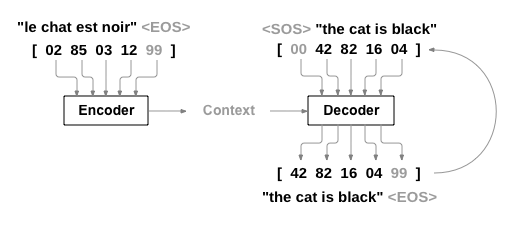

모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리 Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에 두 언어 사이의 번역에 이상적입니다.

다음 문장 “Je ne suis pas le chat noir” → “I am not the black cat” 를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서 직역(“chat noir” 와 “black cat”)되지만 약간 다른 순서도 있습니다. “ne/pas” 구조로 인해 입력 문장에 단어가 하나 더 있습니다. 입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는 것은 어려울 것입니다.

Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다. 이상적인 경우에 입력 시퀀스의 “의미”를 문장의 N 차원 공간에 있는 단일 지점인 단일 벡터으로 인코딩합니다.

## 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

### 전체적인 과정 요약
- t시점에 특정 단어가 input으로 들어오면 embedding을 통해 해당 단어를 벡터로 표시하고, 해당 값과 t-1시점의 hidden state 출력 값을 GRU 셀에 인풋으로 넣는다.
- GRU 셀의 출력은 두 가지 이용되는데 하나는 다음 Hidden state 셀에 입력이 되고, 나머지 하나는 output list에 삽입된다. 

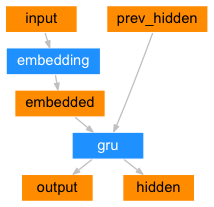

#### ____init____ function
- 해당 function은 class가 생성될 때 구조를 정의해주는 기능을 한다. 
- nn.module을 상속받고, RNN구조를 설정해주는데, hidden_size 설정을 통해서 hidden cell의 output의 size를 설정해준다. 
- 그리고 embedding 클래스를 호출하여, input_size의 input_data를 받으면 hidden_size의 vector로 embedding한다.
- 마지막으로 Hidden cell은 연산속도가 비교적 빠른 GRU cell을 이용하며, input(embedding을 거쳤으므로)과 hidden_state 모두 크기가 hidden_size기이 때문에, 두 개의 인풋 사이즈가 hidden_size로 동일하다.

#### foward function
- 해당 function은 데이터가 output으로 나오기까지의 과정을 보여주는 함수이다.
- 처음 input_data는 embedding 과정을 거치는데, (1,1,-1)은 sequence = 1, batch_size = 1, input_size 만 n인 것으로 해석가능하며, 한 문장이 잘려서 들어오는 것이 아닌, 통째로 하나의 vector로 들어가고 있음을 확인할 수 있다. 
- embedding함수를 통해 나온 값을 gru 셀에 넣어준다. 그리고 gru의 출력 값을 return 받는다.

#### initHidden function
- 해당 함수는 첫 hidden_state 를 0으로 만들어주는 함수이다.



In [ ]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__() ##nn.Module 상속.
        
        self.hidden_size = hidden_size #Hidden size는 Hidden cell의 유닛 개수.

        self.embedding = nn.Embedding(input_size, hidden_size) #input을 embedding하는 함수.input은 hidden size 크기로 embedding된다.

        self.gru = nn.GRU(hidden_size, hidden_size) #input이 embedding되면 hidden_size가 되기 때문에 hiddensize가 input이 된다. 

    def forward(self, input, hidden):

        embedded = self.embedding(input).view(1, 1, -1) #input을 embedding 및 차원 변경. 1개의 sequence == Hidden cell의 개수, 1개의 row(batch_size), n개의 column

        output = embedded  #output은 embedding된 하나의 input sequence임.(hidden_size와 같다)

        output, hidden = self.gru(output, hidden) #GRU에서 input은 input sequence와 hidden state 출력 값 2개가 된다.

        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device) ##1개의 sequence == Hidden cell의 개수, 1개의 row, n개의 column

## 디코더
디코더는 인코더의 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력합니다.

### 간단한 디코더 과정 
- 가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 문맥 벡터(context vector)로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로 사용 됩니다.

- 디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다. 초기 입력 토큰은 문자열-시작(start-of-string) <SOS> 토큰이고, 첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태)입니다. 


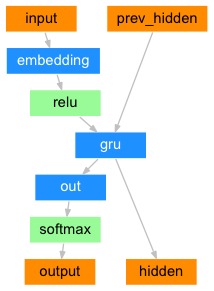

#### init function
- Decoder의 구조를 정의해주는 function으로써, 클래스가 호출될 때 가장 먼저 실행되는 함수이다.
- nn.Module을 상속받는다. 
- Hidden_size를 정의하고, embedding 구조를 정의한다. embedding은 이전 output이 input으로 들어가서 hidden size로 embbeding 되어 나온다.
- GRU 셀을 사용하며, input 2개의 형식이 모두 hidden_size이다. 
- output을 뽑아내기전 Linear 계층을 거친다. RNN에서 fc(fully-connected)를 거치는 것과 동일.
- Linear 계층을 거친 vector를 softmax함수를 한번 더 거치는데, 이는 최종적으로 나올 확률이 가장 높은 값을 도출하기 위함이다. dim=1은 한 row를 기준으로 확률을 구하겠다는 것이고, dim=0은 한 column을 기준으로 확률을 구하는 것이다.

#### forward function
- decoder에서 데이터를 어떻게 흘려보낼지를 정의하는 함수이다.
- 가장 최초에는 embedding함수를 호출해 input을 embedding해준다. 
- 다음 relu 함수(activation function)을 거친다. 왜 하는지는 모르겠다. 아마도 embedding된 vector 중, 쓸데없는 것을 거를려고 하는 것인가? 
- relu 함수의 출력 값과 이전 hidden state의 값을 gru셀에 넣어준다. gru셀의 출력은 output과 hidden state 두 개이다.
- gru셀의 출력 값을 init function에서 설계한 linear 함수에 넣어주기 위해 out 변수에 저장된 out.Linear 함수를 호출하여 파라미터로 넣어주고 출력 값을 softmax함수를 거쳐서 최종 output으로 나오게 된다. 

#### initHidden function
- 해당 함수는 h0를 0으로 만들기 위한 함수이다.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size #hidden size가 input이 된다.

        self.embedding = nn.Embedding(output_size, hidden_size) #최종 output(어떤 단어)가 다시 embedding되어야 한다.
        
        self.gru = nn.GRU(hidden_size, hidden_size) #input,output 모두 hidden size이다.
        
        self.out = nn.Linear(hidden_size, output_size) #output에는 linear 모델을 적용했다.
        
        self.softmax = nn.LogSoftmax(dim=1)    #output결과를 softmax하기 위함이다. 왜 dim=1의 의미는 row를 기준으로 확률을 나눈다는 의미.

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1) #단어 embedding하기.
        output = F.relu(output) #relu함수 거치기.
        output, hidden = self.gru(output, hidden) #gru셀 거치기.
        output = self.softmax(self.out(output[0])) #output을 softmax에 넣기.
        return output, hidden #softmax 통과 값과 hidden state값 넣기.

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 학습하기

#### 학습 데이터 준비
학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 모델 학습 
학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적합니다. 그런 다음 디코더에 첫 번째 입력으로 <SOS> 토큰과 인코더의 마지막 은닉 상태가 첫번쩨 은닉 상태로 제공됩니다.

#### 학습 과정 설명.(코드 순서대로)
1. 초기화 및 기초 파라미터 정의
- encoder_hidden의 초기값 h0를 0으로 초기화 시킵니다.
- encoder_optimizer와 decoder_optimizer의 값을 0으로 초기화 시킵니다.(변수 초기화 하듯)
- input의 길이와 target의 길이를 정의합니다. input_tensor.size(0)은 문장의 개수(row 수)가 출력이 됩니다.  input_tensor와 target_tensor에는 input_data(여러 문장의 데이터)와 target_data(정답 번역 여러 문장)가 들어 있습니다.
- encoder_output의 형태를 정의해줍니다. encoder_output의 형태는 hidden_size만큼의 tensor가 됩니다. 
- loss를 0으로 초기화 해줍니다.


2.1 인코더 학습과정
- input_length(문장의 개수, 한 문장 당 1개의 row)만큼 encoder에 data가 들어가고 output으로 나온 a,와 hidden state 중 hidden state가 다시 encoder에 들어가는 형식입니다.

2.2 디코더 학습과정
- decoder의 input은 초기에는 SOS_token으로 설정하고, decoder의 초기 hidden은 결국 encoder의 마지막 hidden이 되기 때문에 해당 값을 넣어줍니다. 
- decoder는 target_length만큼 반복문을 돌면서 학습합니다. 즉, target_length 문장의 개수만큼 반복문을 돕니다.
- 그리고 학습을 시작합니다. output은 가장 큰 1개의 값이 됩니다. 
- 그리고 각 학습마다 Loss를 계산합니다. 



##### 3. 역전파 및 가중치 업데이트
- loss.backward()를 통해 backpropagation을 진행합니다.
- optimizer.step을 통해 가중치를 업데이트 합니다. 

#### Teacher forcing(해당 예제에서는 사용 X)
- **“Teacher forcing”**은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다. “Teacher forcing”을 사용하면 **수렴이 빨리되지만 학습된 네트워크가 잘못 사용될 때 불안정성**을 보입니다.
- Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 “선택” 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.
- PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로 Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. 더 많이 사용하려면 teacher_forcing_ratio 를 확인하십시오.

In [ ]:
teacher_forcing_ratio = 0.5
#train함수.
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    #Encoder_Hidden init시키기. h0 0으로 만들기.
    encoder_hidden = encoder.initHidden()

    #Encoder, Decoder 기울기 초기화(0으로 만들기)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    #input, target 사이즈 지정, input_tensor의 row 개수.
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    #encoder의 output 형태 지정.
    encoder_outputs = torch.zeros(encoder.hidden_size, device=device)

    loss = 0

    #input_length의 길이 만큼 반복문이 들어가야한다.
    for ei in range(input_length):
      #input_tensor에서 하나씩(input_data_), 이전 hidden state를 또 하나의 인풋으로 넣어서. 학습. output은 2개임.
      _ , encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      #encoder_outputs[ei] = encoder_output[0, 0]  #가장 앞에 것을 뽑아오는 것 같음.attention 구조에서 쓰이는 것임.
    
    decoder_input = torch.tensor([[SOS_token]], device=device)#Decoder에서는 처음에는 SOS_token으로 시작한다. 

    decoder_hidden = encoder_hidden  #Hidden_size는 여기서는 같다. 
    
    #target_length의 길이만큼 반복문이 들어가야 한다.
    for di in range(target_length):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)
        _, topi = decoder_output.topk(1) #결과 중 값이 큰 순으로 1개. _는 가장 큰 값, topi는 해당 값 index
        decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        loss += criterion(decoder_output, target_tensor[di]) #lossfunction 계산해서 loss에 더해주기.

        #EOS_token이 나오면 문장이 끝난걸로 간주하고 멈춤
        if decoder_input.item() == EOS_token:
            break
    
    # 역전파 단계.
    loss.backward()

    # Update parameters , 파라미터 update
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
x = torch.Tensor([[1,12,3,223.5,100],[1,12,3,2266.5,103]])
x.size(0)

2

In [ ]:
a , b =x.topk(1)

In [ ]:
a

tensor([[ 223.5000],
        [2266.5000]])

In [ ]:
#b
b.squeeze()

tensor([3, 3])

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

- 타이머 시작

- optimizers와 criterion(Lossfunction) 초기화

- 학습 쌍의 세트 생성

- 도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 train 을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    #optimizer, criterion 초기화
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #training data 전처리 과정 중 하나.
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    
    for iter in range(1, n_iters + 1):
      #학습 쌍 세트 생성.
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

      #학습을 통해 loss계산 및 도식화.
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 결과 도식화
matplotlib로 학습 중에 저장된 손실 값 plot_losses 의 배열을 사용하여 도식화합니다.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 평가
평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 **디코더의 예측을 되돌려 전달**합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 **EOS 토큰을 예측하면 거기에서 멈춥니다.** 나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():# autograd가 .requires_grad=True 인 Tensor들의 연산 기록을 추적하는 것을 멈출 수 있습니다.
        input_tensor = tensorFromSentence(input_lang, sentence) #input_tensor생성.
        input_length = input_tensor.size()[0] #input의 사이즈 == 총 데이터의 개수(여러 문장)
        encoder_hidden = encoder.initHidden()#h0 초기화.

        encoder_outputs = torch.zeros(encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        
            _ , topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
k = torch.zeros(5,10)
k

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### 학습과 평가
이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을 더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을 시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의 경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은 네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에 합리적인 결과를 얻을 것입니다.

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)

0m 50s (- 11m 40s) (5000 6%) 2.9925
1m 37s (- 10m 34s) (10000 13%) 2.4814
2m 25s (- 9m 41s) (15000 20%) 2.1764
3m 13s (- 8m 51s) (20000 26%) 1.9152
4m 1s (- 8m 3s) (25000 33%) 1.6680
4m 50s (- 7m 15s) (30000 40%) 1.4909
5m 38s (- 6m 27s) (35000 46%) 1.3289
6m 27s (- 5m 38s) (40000 53%) 1.1678
7m 15s (- 4m 50s) (45000 60%) 1.0561
8m 4s (- 4m 2s) (50000 66%) 0.9748
8m 52s (- 3m 13s) (55000 73%) 0.8903
9m 41s (- 2m 25s) (60000 80%) 0.7736
10m 29s (- 1m 36s) (65000 86%) 0.7130
11m 18s (- 0m 48s) (70000 93%) 0.6301
12m 6s (- 0m 0s) (75000 100%) 0.6039


In [ ]:
evaluateRandomly(encoder1, decoder1)

In [ ]:
input_lang.n_words

4345

참고자료 : 
- nn.LogSoftmax(dim=1)에서 dim = 1이 의미하는 것은 무엇인가?
https://discuss.pytorch.org/t/dimension-for-logsoftmax/49042